In [1]:
!apt-get update --quiet > /dev/null 2>&1
!apt-get install -y chromium-chromedriver --quiet > /dev/null 2>&1
!cp /usr/lib/chromium-browser/chromedriver /usr/bin --quiet > /dev/null 2>&1
!pip install selenium --quiet > /dev/null 2>&1
!pip install beautifulsoup4 --quiet > /dev/null 2>&1

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

In [3]:
# Selenium設定
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
driver = webdriver.Chrome(options=options)

📰 最新記事（トップ5）


,date,title,url
15,2025-05-25,2中国海軍 尖閣沖で空母が戦闘機の発着実施 自衛隊機が緊急発進,https://www3.nhk.or.jp/news/html/20250525/k100...
14,2025-05-25,マンション高騰 外国人投資の実態初調査へ【経済コラム】,https://www3.nhk.or.jp/news/html/20250523/k100...
12,2025-05-26,【Q＆A】戸籍の氏名に読みがな記載 運用開始 「通知書」確認を,https://www3.nhk.or.jp/news/html/20250526/k100...
0,2025-05-27,小泉農相 備蓄米売り渡し 購入申請を一時休止“予定量上限に”,https://www3.nhk.or.jp/news/html/20250527/k100...
18,2025-05-27,5基礎年金底上げ正式合意 自民・公明・立民 党首会談,https://www3.nhk.or.jp/news/html/20250527/k100...


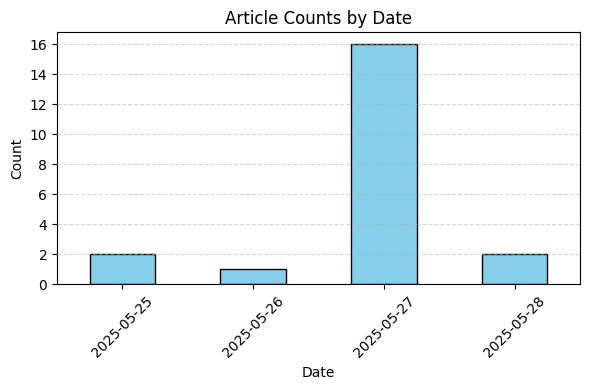

In [5]:
# NHKトップページアクセス
base_url = 'https://www3.nhk.or.jp/news/'
driver.get(base_url)
time.sleep(5)

# 記事リンクの収集 (最大30件)
soup = BeautifulSoup(driver.page_source, 'html.parser')
seen = set()
target_articles = []

for a_tag in soup.find_all('a', href=True):
    title = a_tag.get_text(strip=True)
    href = a_tag['href']
    if title and href.startswith('/news/html/') and 'html' in href:
        full_url = 'https://www3.nhk.or.jp' + href
        if full_url not in seen:
            seen.add(full_url)
            target_articles.append({"title": title, "url": full_url})
    if len(target_articles) >= 30:
        break

# 各記事ページで日付を取得
results = []

for article in target_articles:
    try:
        driver.get(article["url"])
        time.sleep(0.5)
        detail_soup = BeautifulSoup(driver.page_source, "html.parser")

        time_tag = detail_soup.find("time")
        if time_tag and time_tag.has_attr("datetime"):
            pub_date = time_tag["datetime"].split("T")[0]
        else:
            pub_date = datetime.today().strftime("%Y-%m-%d")

        results.append({
            "date": pub_date,
            "title": article["title"],
            "url": article["url"]
        })

    except Exception as e:
        print("スキップ：", article["url"], str(e))

# ドライバー終了
driver.quit()

# DataFrame化
df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# 表：上位5件のニュース記事
print("📰 最新記事（トップ5）")
display(df[["date", "title", "url"]].head())

# 棒グラフで日別記事数を可視化
df["date_only"] = df["date"].dt.date
counts = df["date_only"].value_counts().sort_index()

counts.plot(kind="bar", figsize=(6, 4), color="skyblue", edgecolor="black")
plt.title("Article Counts by Date")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()